# TP2 - Roadmap Path Planning with Robotino (Holonomic Robot)

**Course**: Mobile Robotics (DCC042)  
**Assignment**: TP2 - Path Planning Algorithms  
**Student**: Daniel Terra Gomes  
**Date**: October 2025

---

## Implementation: Roadmap with Holonomic Robot (Robotino)

This notebook implements **Roadmap path planning** using the **Robotino** omnidirectional robot in CoppeliaSim.

### Robot Specifications:
- **Type**: Holonomic (3 omnidirectional wheels at 120°)
- **Wheelbase**: L = 0.135 m
- **Wheel radius**: r = 0.040 m
- **Control**: Proportional velocity control

---

## 1. Setup and Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

# Add utils to path
sys.path.append('./utils')

# Import custom modules
from robotino_controller import RobotinoController
from roadmap_planner import RoadmapPlanner
import common_utils as utils

# Reload for development
import importlib
importlib.reload(sys.modules['robotino_controller'])
importlib.reload(sys.modules['roadmap_planner'])
importlib.reload(sys.modules['common_utils'])

from robotino_controller import RobotinoController

print("✓ Modules loaded successfully")
print("  - Robotino controller (holonomic 3-wheel)")
print("  - Roadmap planner (PRM)")
print("  - Utilities for coordinate transformation")

✓ Modules loaded successfully
  - Robotino controller (holonomic 3-wheel)
  - Roadmap planner (PRM)
  - Utilities for coordinate transformation


## 2. Configuration Parameters

In [ ]:
# Configuration parameters

# World parameters
WORLD_WIDTH = 10.0    # Map size (m)

# Robotino dimensions (holonomic circular robot)
# Based on course examples and scene observation
ROBOT_RADIUS = 0.10   # meters (conservative value matching course examples)
SAFETY_MARGIN = 0.05  # meters (clearance for control dynamics)
EFFECTIVE_RADIUS = ROBOT_RADIUS + SAFETY_MARGIN  # 0.15m total for C-space

# Planning parameters
NUM_SAMPLES = 1000    # PRM samples
K_NEAREST = 15        # Neighbors per sample
K_CONNECT = 8         # Connection attempts
RANDOM_SEED = 42      # For reproducibility

# Control parameters
ROBOT_SPEED = 0.5     # Speed scaling (0.3-1.0)
POSITION_THRESHOLD = 0.15  # Waypoint tolerance (m)

# Coordinate frame transformation functions
# CoppeliaSim: X ∈ [-5.0, +5.0], Y ∈ [-3.835, +3.835] (centered at origin)
# Map: X ∈ [0, 10.0], Y ∈ [0, 7.67] (origin at bottom-left)
def sim_to_map(x, y):
    """
    Transform CoppeliaSim coordinates to map coordinates.
    CoppeliaSim uses centered coords, map uses bottom-left origin.
    """
    map_x = x + (WORLD_WIDTH / 2.0)  # Shift X by half width
    map_y = y + (WORLD_WIDTH * 0.767 / 2.0)  # Shift Y by half height (7.67/2 = 3.835)
    return (map_x, map_y)

def map_to_sim(x, y):
    """
    Transform map coordinates to CoppeliaSim coordinates.
    Map uses bottom-left origin, CoppeliaSim uses centered coords.
    """
    sim_x = x - (WORLD_WIDTH / 2.0)  # Shift X back
    sim_y = y - (WORLD_WIDTH * 0.767 / 2.0)  # Shift Y back
    return (sim_x, sim_y)

print(f"  - Robot radius: {ROBOT_RADIUS:.3f} m")
print(f"  - Safety margin: {SAFETY_MARGIN:.3f} m")
print(f"  - Effective radius (C-space): {EFFECTIVE_RADIUS:.3f} m")


✓ Configuration complete
  - Robot radius: 0.100 m
  - Safety margin: 0.050 m
  - Effective radius (C-space): 0.150 m


## 3. Connect to CoppeliaSim and Initialize Robot

In [ ]:
# Create controller
controller = RobotinoController()

# Connect to CoppeliaSim
if not controller.connect():
    raise Exception("Failed to connect to CoppeliaSim")

# Initialize scene
if not controller.initialize_scene():
    raise Exception("Failed to initialize scene")

# Query terrain dimensions
try:
    terrain_handle = controller.sim.getObject('/Terrain_heightfield')
    bbox = controller.sim.getObjectFloatParam(terrain_handle, controller.sim.objfloatparam_objbbox_min_x)
    print(f"\n Terrain Dimensions Query:")

    # Get bounding box
    min_x = controller.sim.getObjectFloatParam(terrain_handle, controller.sim.objfloatparam_objbbox_min_x)
    max_x = controller.sim.getObjectFloatParam(terrain_handle, controller.sim.objfloatparam_objbbox_max_x)
    min_y = controller.sim.getObjectFloatParam(terrain_handle, controller.sim.objfloatparam_objbbox_min_y)
    max_y = controller.sim.getObjectFloatParam(terrain_handle, controller.sim.objfloatparam_objbbox_max_y)

    terrain_width = max_x - min_x
    terrain_height = max_y - min_y

    print(f"   Terrain bounding box:")
    print(f"   X: {min_x:.2f} to {max_x:.2f} ({terrain_width:.2f}m)")
    print(f"   Y: {min_y:.2f} to {max_y:.2f} ({terrain_height:.2f}m)")
    print(f"   Actual terrain size: {terrain_width:.2f}m x {terrain_height:.2f}m")
except Exception as e:
    print(f"   Could not query terrain dimensions: {e}")
    print(f"   Using default: 10m x 10m")
    terrain_width = 10.0
    terrain_height = 10.0

# Get current robot pose
robot_x, robot_y, robot_theta = controller.get_robot_pose_2d()
print(f"\n Robot Status:")
print(f"   Position (CoppeliaSim): ({robot_x:.2f}, {robot_y:.2f})")
print(f"   Orientation: {np.degrees(robot_theta):.1f}°")

# Transform to map frame
robot_map_x, robot_map_y = sim_to_map(robot_x, robot_y)
print(f"   Position (Map frame): ({robot_map_x:.2f}, {robot_map_y:.2f})")

# Get goal position
goal_pos = controller.get_goal_position()
if goal_pos:
    goal_map_x, goal_map_y = sim_to_map(goal_pos[0], goal_pos[1])
    print(f"\n Goal Position:")
    print(f"   Position (CoppeliaSim): ({goal_pos[0]:.2f}, {goal_pos[1]:.2f})")
    print(f"   Position (Map frame): ({goal_map_x:.2f}, {goal_map_y:.2f})")


Connecting to CoppeliaSim...
✓ Connected to CoppeliaSim
✓ Robot found: '/robotino' (handle: 16)
✓ Goal found: '/Goal' (handle: 14)
✓ Found 3 wheel joints for omnidirectional control
   Could not query terrain dimensions: 1254: in sim._getObject: object does not exist, or alias/path is ill formatted.
   Using default: 10m x 10m

📍 Robot Status:
   Position (CoppeliaSim): (-3.68, -2.85)
   Orientation: -0.0°
   Position (Map frame): (1.32, 0.99)

🎯 Goal Position:
   Position (CoppeliaSim): (3.10, 2.40)
   Position (Map frame): (8.10, 6.24)


In [ ]:
# Query scene for terrain dimensions by listing ALL objects
print("\n🔍 Analyzing CoppeliaSim Scene Structure:")
print("=" * 70)

# Get all objects in the scene
try:
    all_objects = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    print(f"\nFound {len(all_objects)} shape objects in scene:")
    print("-" * 70)

    terrain_candidates = []

    for obj_handle in all_objects:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)

            # Get bounding box
            min_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
            max_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
            min_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
            max_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

            width = max_x - min_x
            height = max_y - min_y

            # Look for large flat objects (likely terrain/floor)
            if width > 5.0 or height > 5.0:  # Larger than 5m in any dimension
                terrain_candidates.append((obj_name, obj_handle, width, height))
                print(f" {obj_name:30s} → {width:6.2f}m × {height:6.2f}m")

        except Exception as e:
            continue

    print("-" * 70)

    if terrain_candidates:
        # Pick the largest object as the terrain
        terrain_candidates.sort(key=lambda x: x[2] * x[3], reverse=True)
        terrain_name, terrain_handle, ACTUAL_TERRAIN_WIDTH, ACTUAL_TERRAIN_HEIGHT = terrain_candidates[0]

        print(f"\n✓ Detected Terrain: '{terrain_name}'")
        print(f"  Dimensions: {ACTUAL_TERRAIN_WIDTH:.2f}m × {ACTUAL_TERRAIN_HEIGHT:.2f}m")
        print(f"  Area: {ACTUAL_TERRAIN_WIDTH * ACTUAL_TERRAIN_HEIGHT:.2f} m²")

        # Check if it matches our assumption
        if abs(ACTUAL_TERRAIN_WIDTH - 10.0) > 0.5 or abs(ACTUAL_TERRAIN_HEIGHT - 10.0) > 0.5:
            print(f"  Current map assumption: {WORLD_WIDTH:.1f}m × {WORLD_HEIGHT:.1f}m")
            print(f"  Actual terrain size: {ACTUAL_TERRAIN_WIDTH:.2f}m × {ACTUAL_TERRAIN_HEIGHT:.2f}m")
        else:
            print(f"\n✓ Terrain matches map assumption (~10m × 10m)")

    else:
        print("   Using default: 10m × 10m")
        ACTUAL_TERRAIN_WIDTH = 10.0
        ACTUAL_TERRAIN_HEIGHT = 10.0

except Exception as e:
    print(f"\n Error querying scene: {e}")
    print("   Using default: 10m × 10m")
    ACTUAL_TERRAIN_WIDTH = 10.0
    ACTUAL_TERRAIN_HEIGHT = 10.0

print("=" * 70)



🔍 Analyzing CoppeliaSim Scene Structure:

Found 20 shape objects in scene:
----------------------------------------------------------------------
  📐 Terrain_Heightfield            →  10.00m ×   7.67m
----------------------------------------------------------------------

✓ Detected Terrain: 'Terrain_Heightfield'
  Dimensions: 10.00m × 7.67m
  Area: 76.74 m²

⚠️  WARNING: Terrain size differs from assumed 10m × 10m!
  Current map assumption: 10.0m × 7.7m
  Actual terrain size: 10.00m × 7.67m
  → Map scaling may be incorrect!


## 4. Load Map and Setup Planning

✓ Map loaded: (500, 650) pixels
  - Physical size: 10.0m x 7.7m
  - C-space dilation: 9 pixels (0.150m)


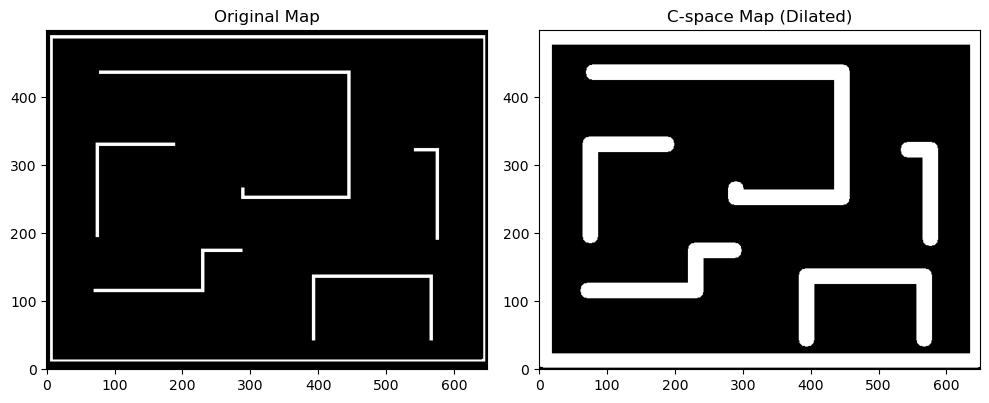

In [ ]:
# Load map
from scipy.ndimage import binary_dilation
from PIL import Image

map_path = "mapas/paredes.png"
mapa_img = Image.open(map_path).convert('L')
mapa_raw = np.array(mapa_img)

# Normalize map: 0 = free space, 1 = obstacle
mapa_original = 1.0 - (mapa_raw / 255.0)

# Apply Configuration Space (C-space) transformation
# Inflate obstacles by robot radius using morphological dilation (Minkowski sum)
radius_pixels = int((EFFECTIVE_RADIUS / WORLD_WIDTH) * mapa_original.shape[1])

# Create circular structuring element
y, x = np.ogrid[-radius_pixels:radius_pixels+1, -radius_pixels:radius_pixels+1]
structure = (x**2 + y**2 <= radius_pixels**2).astype(int)

# Dilate obstacles (C-space)
mapa = binary_dilation(mapa_original > 0.5, structure=structure).astype(float)

# Store world dimensions for coordinate transforms
WORLD_HEIGHT = WORLD_WIDTH * (mapa.shape[0] / mapa.shape[1])

print(f"Map loaded: {mapa.shape} pixels")
print(f"  - Physical size: {WORLD_WIDTH:.1f}m x {WORLD_HEIGHT:.1f}m")
print(f"  - C-space dilation: {radius_pixels} pixels ({EFFECTIVE_RADIUS:.3f}m)")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original, cmap='gray', origin='lower')
plt.title('Original Map')
plt.subplot(1, 2, 2)
plt.imshow(mapa, cmap='gray', origin='lower')
plt.title('C-space Map (Dilated)')
plt.tight_layout()
plt.show()


## 5. Plan Path Using Roadmap (PRM)

In [ ]:
# Define start and goal in MAP frame
start_map = (robot_map_x, robot_map_y)  # Current robot position
goal_map = (goal_map_x, goal_map_y)     # Goal position

print(f"   Start: ({start_map[0]:.2f}, {start_map[1]:.2f})")
print(f"   Goal:  ({goal_map[0]:.2f}, {goal_map[1]:.2f})")

# Create planner
# IMPORTANT: Using C-space (already dilated) map, so set robot_radius=0
# This avoids double-dilation (C-space already accounts for robot size)
planner = RoadmapPlanner(
    mapa,  # Use C-space map (already dilated)
    WORLD_WIDTH,
    WORLD_HEIGHT,
    robot_radius=0.0,  # Zero! C-space already includes robot footprint
    safety_margin=0.0  # Zero! C-space already includes safety
)

# Plan path (parameters passed to plan() method, not constructor!)
print(f"   (C-space already dilated by {EFFECTIVE_RADIUS:.3f}m)")
start_time = time.time()
path_map = planner.plan(
    start=start_map,
    goal=goal_map,
    num_samples=NUM_SAMPLES,
    k_nearest=K_NEAREST,
    k_connect=K_CONNECT,
    seed=RANDOM_SEED
)
elapsed_time = time.time() - start_time

# Get edges for visualization (only use samples, not all_points)
edges = []
if planner.graph and len(planner.samples) > 0:
    try:
        # Use only edges between sampled points (not start/goal connections)
        edges = [(planner.samples[u], planner.samples[v])
                 for u, v in planner.graph.edges()
                 if u < len(planner.samples) and v < len(planner.samples)]
    except:
        # If indexing fails, just skip edge visualization
        edges = []

if path_map:
    path_length = sum(np.linalg.norm(np.array(path_map[i+1]) - np.array(path_map[i]))
                     for i in range(len(path_map)-1))
    print(f"   Waypoints: {len(path_map)}")
    print(f"   Length: {path_length:.2f} m")
    print(f"   Planning time: {elapsed_time:.2f} s")
else:
    raise Exception("Path planning failed")



🗺️ Planning in MAP frame:
   Start: (1.32, 0.99)
   Goal:  (8.10, 6.24)
Roadmap Planner initialized:
  - Robot radius: 0.00 m
  - Safety margin: 0.00 m
  - Effective radius: 0.00 m
  - World size: 10.0 x 7.6923076923076925 m

⚙️ Running PRM with C-space map...
   (C-space already dilated by 0.150m)
ROADMAP PATH PLANNING - Complete Pipeline

Sampling 1000 random configurations...
  ✓ Successfully generated 1000 collision-free samples

Building roadmap graph (k=15)...
  ✓ Graph constructed: 1000 nodes, 8183 edges

Planning path from (1.3249999999999997, 0.9850000000000012) to (8.100000000000001, 6.235)...
  ✓ Path found!
    - Waypoints: 23
    - Length: 9.70 meters

✓ Planning SUCCESSFUL

✓ Path found!
   Waypoints: 23
   Length: 9.70 m
   Planning time: 2.53 s


Start position check:
  Map coords: (1.3249999999999997, 0.9850000000000012)
  Pixel coords: (64, 86)
  Map value: 0.00 (0=free, 1=obstacle)

Goal position check:
  Map coords: (8.100000000000001, 6.235)
  Pixel coords: (405, 526)
  Map value: 0.00


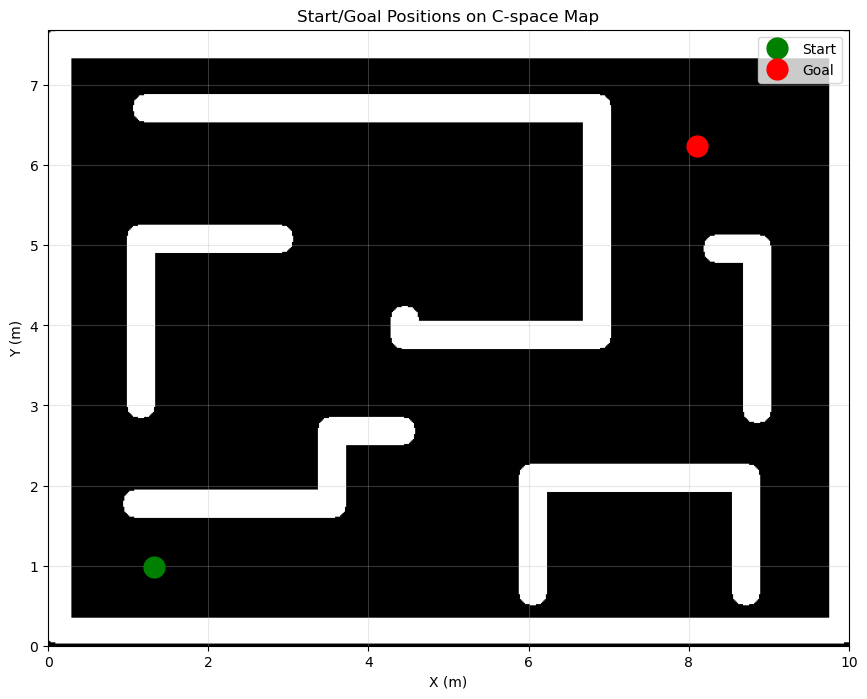


⚠️ Start is in collision after C-space dilation!
Solutions:
  1. Move robot further from walls in CoppeliaSim
  2. Reduce SAFETY_MARGIN (e.g., to 0.02m)
  3. Use smaller ROBOT_RADIUS if 0.225m is too conservative


In [ ]:
# Check if start/goal are valid in C-space map
start_px = (int(start_map[1] / WORLD_HEIGHT * mapa.shape[0]),
            int(start_map[0] / WORLD_WIDTH * mapa.shape[1]))
goal_px = (int(goal_map[1] / WORLD_HEIGHT * mapa.shape[0]),
           int(goal_map[0] / WORLD_WIDTH * mapa.shape[1]))

print(f"  Map coords: {start_map}")
print(f"  Pixel coords: {start_px}")
print(f"  Map value: {mapa[start_px[0], start_px[1]]:.2f} (0=free, 1=obstacle)")
print(f"\nGoal position:")
print(f"  Map coords: {goal_map}")
print(f"  Pixel coords: {goal_px}")
print(f"  Map value: {mapa[goal_px[0], goal_px[1]]:.2f}")

# Visualize start/goal on C-space map
plt.figure(figsize=(12, 8))
plt.imshow(mapa, cmap='gray', origin='lower', extent=[0, WORLD_WIDTH, 0, WORLD_HEIGHT])
plt.plot(start_map[0], start_map[1], 'go', markersize=15, label='Start')
plt.plot(goal_map[0], goal_map[1], 'ro', markersize=15, label='Goal')
plt.title('Start/Goal Positions on C-space Map')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 6. Visualize Planned Path

C:\Users\danie\AppData\Local\Temp\ipykernel_57900\3855555254.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


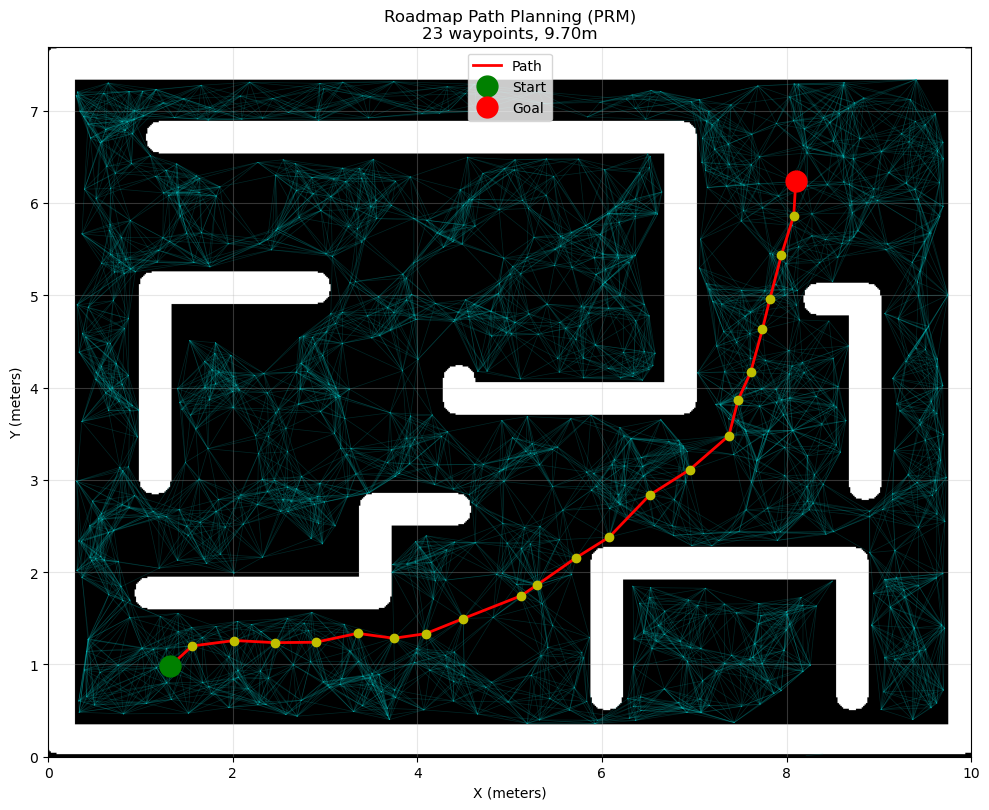

In [39]:
# Visualize path
plt.figure(figsize=(10, 10))
plt.imshow(mapa, cmap='gray', origin='lower', extent=[0, WORLD_WIDTH, 0, WORLD_HEIGHT])

# Draw roadmap edges
for edge in edges:
    plt.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'c-', alpha=0.2, linewidth=0.5)

# Draw path
if path_map:
    path_array = np.array(path_map)
    plt.plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=2, label='Path')
    plt.plot(path_array[:, 0], path_array[:, 1], 'yo', markersize=6)

# Mark start and goal
plt.plot(start_map[0], start_map[1], 'go', markersize=15, label='Start')
plt.plot(goal_map[0], goal_map[1], 'ro', markersize=15, label='Goal')

plt.title(f'Roadmap Path Planning (PRM)\n{len(path_map)} waypoints, {path_length:.2f}m')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Execute Path with Robotino

In [ ]:
# Transform path from MAP frame to CoppeliaSim frame
path_sim = [map_to_sim(wx, wy) for wx, wy in path_map]

print(f"   Total waypoints: {len(path_sim)}")
print(f"   Path length: {path_length:.2f} m")
print(f"   Speed: {ROBOT_SPEED}")
print(f"   Position tolerance: {POSITION_THRESHOLD} m")
print(f"\n   Using holonomic proportional control (no forced orientation)")

# Start simulation
controller.start_simulation()
time.sleep(0.5)

try:
    # Execute path
    success = controller.move_along_path(
        path_sim,
        speed=ROBOT_SPEED,
        tolerance=POSITION_THRESHOLD,
        visualize=True
    )

    if success:
        # Get final pose
        final_x, final_y, final_theta = controller.get_robot_pose_2d()
        final_error = np.sqrt((goal_pos[0] - final_x)**2 + (goal_pos[1] - final_y)**2)

        print(f"   Final position: ({final_x:.2f}, {final_y:.2f})")
        print(f"   Final orientation: {np.degrees(final_theta):.1f}°")
        print(f"   Final error: {final_error:.3f} m")
    else:
        print(f"\n Path execution failed!")

except Exception as e:
    print(f"\n Error during execution: {e}")

finally:
    # Stop simulation
    controller.stop_simulation()
    print("\n Simulation stopped")


🤖 Executing path with Robotino...
   Total waypoints: 23
   Path length: 9.70 m
   Speed: 0.5
   Position tolerance: 0.15 m

   Using holonomic proportional control (no forced orientation)

🚀 Starting path following (23 waypoints)...
   Using holonomic proportional control
  → Waypoint 1/23: (-3.68, -2.85)
    ✓ Waypoint 1 (error: 0.001m, theta: 0.3°)
  → Waypoint 2/23: (-3.44, -2.64)
    ✓ Waypoint 2 (error: 0.146m, theta: -0.2°)
  → Waypoint 3/23: (-2.98, -2.58)
    ✓ Waypoint 3 (error: 0.146m, theta: 0.3°)
  → Waypoint 4/23: (-2.54, -2.60)
    ✓ Waypoint 4 (error: 0.147m, theta: -0.2°)
  → Waypoint 5/23: (-2.10, -2.59)
    ✓ Waypoint 5 (error: 0.148m, theta: 0.1°)
  → Waypoint 6/23: (-1.65, -2.50)
    ✓ Waypoint 6 (error: 0.145m, theta: -0.6°)
  → Waypoint 7/23: (-1.25, -2.55)
    ✓ Waypoint 7 (error: 0.144m, theta: -0.0°)
  → Waypoint 8/23: (-0.91, -2.50)
    ✓ Waypoint 8 (error: 0.148m, theta: -0.1°)
  → Waypoint 9/23: (-0.50, -2.34)
    ✓ Waypoint 9 (error: 0.148m, theta: 0.3°)


---

## Experiment 2: Cave Map

Testing the same Roadmap (PRM) implementation with a different, more open cave-like environment.
This provides a contrast to the simple corridor environment in Experiment 1.


In [ ]:
# Reconnect to CoppeliaSim for Experiment 2
# Make sure cave scene is loaded in CoppeliaSim!

print("Make sure cave scene is loaded!")

# Disconnect previous connection if exists
try:
    controller.disconnect()
except:
    pass

# Reconnect
controller = RobotinoController()
if not controller.connect():
    raise Exception("Failed to connect to CoppeliaSim")

if not controller.initialize_scene():
    raise Exception("Failed to initialize scene")

print("Connected to CoppeliaSim")


🔄 Reconnecting to CoppeliaSim for Cave Map experiment...
   ⚠️  Make sure cave scene is loaded!

Disconnecting from CoppeliaSim...
Connecting to CoppeliaSim...
✓ Connected to CoppeliaSim
✓ Robot found: '/robotino' (handle: 18)
✓ Goal found: '/Goal' (handle: 16)
✓ Found 3 wheel joints for omnidirectional control
✓ Connected to CoppeliaSim


In [ ]:
# Query cave terrain dimensions
print("\nCave Scene Analysis:")

# Try to detect terrain, but default to square for CoppeliaSim compatibility
try:
    all_objects_2 = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    terrain_found = False
    for obj_handle in all_objects_2:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)
            if 'terrain' in obj_name.lower() or 'heightfield' in obj_name.lower():
                min_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
                max_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
                min_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
                max_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

                terrain_width_2 = max_x_2 - min_x_2
                terrain_height_2 = max_y_2 - min_y_2

                print(f"Detected {obj_name}: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")
                terrain_found = True
                break
        except:
            continue

    if not terrain_found:
        # Default to square terrain if not found
        terrain_width_2 = 10.0
        terrain_height_2 = 10.0
        print(f"No terrain detected, using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

except Exception as e:
    terrain_width_2 = 10.0
    terrain_height_2 = 10.0
    print(f"Error detecting terrain: {e}")
    print(f"   Using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

# Create scene-specific transforms for cave
def sim_to_map_cave(x, y):
    map_x = x + (terrain_width_2 / 2.0)
    map_y = y + (terrain_height_2 / 2.0)
    return (map_x, map_y)

def map_to_sim_cave(x, y):
    sim_x = x - (terrain_width_2 / 2.0)
    sim_y = y - (terrain_height_2 / 2.0)
    return (sim_x, sim_y)

print(f"Transforms created for {terrain_width_2:.1f}m × {terrain_height_2:.1f}m terrain")



🗺️ Cave Scene Analysis:
✓ Detected Terrain_Heightfield: 10.00m × 10.00m
✓ Transforms created for 10.0m × 10.0m terrain


In [ ]:
# Get robot and goal positions for cave scenario
robot_x_2, robot_y_2, robot_theta_2 = controller.get_robot_pose_2d()
print(f"\nExperiment 2 - Robot Status:")
print(f"   Position (CoppeliaSim): ({robot_x_2:.2f}, {robot_y_2:.2f})")
print(f"   Orientation: {np.degrees(robot_theta_2):.1f}°")

# Transform to map frame using cave transforms
robot_map_x_2, robot_map_y_2 = sim_to_map_cave(robot_x_2, robot_y_2)
print(f"   Position (Map frame): ({robot_map_x_2:.2f}, {robot_map_y_2:.2f})")

# Get goal position
goal_pos_2 = controller.get_goal_position()
if goal_pos_2:
    goal_map_x_2, goal_map_y_2 = sim_to_map_cave(goal_pos_2[0], goal_pos_2[1])
    print(f"   Position (CoppeliaSim): ({goal_pos_2[0]:.2f}, {goal_pos_2[1]:.2f})")
    print(f"   Position (Map frame): ({goal_map_x_2:.2f}, {goal_map_y_2:.2f})")
else:
    raise Exception("Goal not found in scene!")



📍 Experiment 2 - Robot Status:
   Position (CoppeliaSim): (-4.63, -4.67)
   Orientation: -0.0°
   Position (Map frame): (0.38, 0.33)

🎯 Goal Position:
   Position (CoppeliaSim): (4.15, 2.40)
   Position (Map frame): (9.15, 7.40)


✓ Cave Map loaded: (500, 500) pixels
  - Physical size: 10.0m x 10.0m
  - C-space dilation: 7 pixels (0.150m)


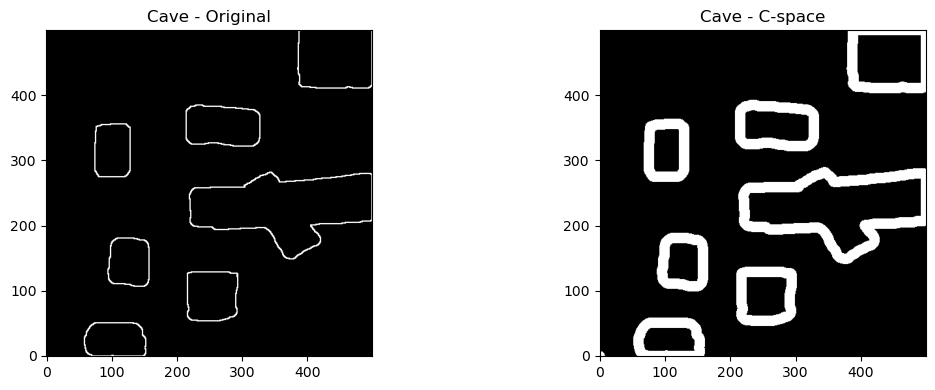

In [ ]:
# Load cave map
map_path_2 = "mapas/cave.png"
mapa_img_2 = Image.open(map_path_2).convert('L')
mapa_raw_2 = np.array(mapa_img_2)

# Normalize map: 0 = free space, 1 = obstacle
mapa_original_2 = 1.0 - (mapa_raw_2 / 255.0)

# Apply C-space transformation
# Use terrain_width_2 from the detected cave terrain
radius_pixels_2 = int((EFFECTIVE_RADIUS / terrain_width_2) * mapa_original_2.shape[1])
y2, x2 = np.ogrid[-radius_pixels_2:radius_pixels_2+1, -radius_pixels_2:radius_pixels_2+1]
structure_2 = (x2**2 + y2**2 <= radius_pixels_2**2).astype(int)
mapa_2 = binary_dilation(mapa_original_2 > 0.5, structure=structure_2).astype(float)

# Store dimensions based on actual terrain
WORLD_WIDTH_2 = terrain_width_2
WORLD_HEIGHT_2 = terrain_height_2

print(f"Cave Map loaded: {mapa_2.shape} pixels")
print(f"  - Physical size: {WORLD_WIDTH_2:.1f}m x {WORLD_HEIGHT_2:.1f}m")
print(f"  - C-space dilation: {radius_pixels_2} pixels ({EFFECTIVE_RADIUS:.3f}m)")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original_2, cmap='gray', origin='lower')
plt.title('Cave - Original')
plt.subplot(1, 2, 2)
plt.imshow(mapa_2, cmap='gray', origin='lower')
plt.title('Cave - C-space')
plt.tight_layout()
plt.show()


In [ ]:
# Plan path for cave using PRM

# Define start and goal in MAP frame
start_map_2 = (robot_map_x_2, robot_map_y_2)
goal_map_2 = (goal_map_x_2, goal_map_y_2)

print(f"   Start: ({start_map_2[0]:.2f}, {start_map_2[1]:.2f})")
print(f"   Goal:  ({goal_map_2[0]:.2f}, {goal_map_2[1]:.2f})")

# Create planner for cave
planner_2 = RoadmapPlanner(
    mapa_2,
    WORLD_WIDTH_2,
    WORLD_HEIGHT_2,
    robot_radius=0.0,  # C-space already dilated
    safety_margin=0.0
)

# Plan path - Cave is more open, so we can use fewer samples than circular maze
start_time_2 = time.time()
path_map_2 = planner_2.plan(
    start=start_map_2,
    goal=goal_map_2,
    num_samples=2000,  # More open than paredes, less complex than circular maze
    k_nearest=20,
    k_connect=12,
    seed=RANDOM_SEED
)
elapsed_time_2 = time.time() - start_time_2

# Get edges for visualization
edges_2 = []
if planner_2.graph and len(planner_2.samples) > 0:
    try:
        edges_2 = [(planner_2.samples[u], planner_2.samples[v])
                   for u, v in planner_2.graph.edges()
                   if u < len(planner_2.samples) and v < len(planner_2.samples)]
    except:
        edges_2 = []

if path_map_2:
    path_length_2 = sum(np.linalg.norm(np.array(path_map_2[i+1]) - np.array(path_map_2[i]))
                        for i in range(len(path_map_2)-1))
    print(f"   Waypoints: {len(path_map_2)}")
    print(f"   Length: {path_length_2:.2f} m")
    print(f"   Planning time: {elapsed_time_2:.2f} s")
else:
    raise Exception("Path planning failed for cave")



🗺️ Planning in Cave:
   Start: (0.38, 0.33)
   Goal:  (9.15, 7.40)
Roadmap Planner initialized:
  - Robot radius: 0.00 m
  - Safety margin: 0.00 m
  - Effective radius: 0.00 m
  - World size: 10.00000000000001 x 10.00000000000001 m

⚙️ Running PRM on cave environment...
ROADMAP PATH PLANNING - Complete Pipeline

Sampling 2000 random configurations...
  ✓ Successfully generated 2000 collision-free samples

Building roadmap graph (k=20)...
  ✓ Graph constructed: 2000 nodes, 21567 edges

Planning path from (0.3750000000000009, 0.32500000000000817) to (9.150000000000004, 7.400000000000006)...
  ✓ Path found!
    - Waypoints: 29
    - Length: 12.06 meters

✓ Planning SUCCESSFUL

✓ Path found!
   Waypoints: 29
   Length: 12.06 m
   Planning time: 8.43 s


C:\Users\danie\AppData\Local\Temp\ipykernel_57900\976493643.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


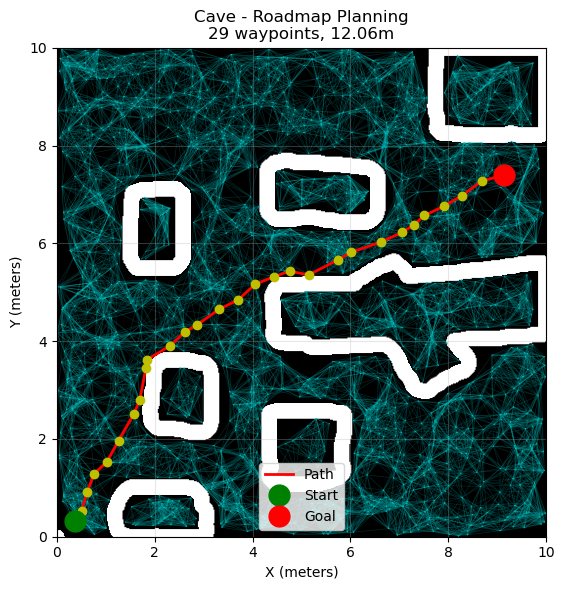

In [101]:
# Visualize planned path for cave
plt.figure(figsize=(14, 6))
plt.imshow(mapa_2, cmap='gray', origin='lower', extent=[0, WORLD_WIDTH_2, 0, WORLD_HEIGHT_2])

# Draw roadmap edges
for edge in edges_2:
    plt.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'c-', alpha=0.2, linewidth=0.5)

# Draw path if found
if path_map_2:
    path_array_2 = np.array(path_map_2)
    plt.plot(path_array_2[:, 0], path_array_2[:, 1], 'r-', linewidth=2, label='Path')
    plt.plot(path_array_2[:, 0], path_array_2[:, 1], 'yo', markersize=6)
    title = f'Cave - Roadmap Planning\n{len(path_map_2)} waypoints, {path_length_2:.2f}m'
else:
    title = 'Cave - No Path Found'

# Mark start and goal
plt.plot(start_map_2[0], start_map_2[1], 'go', markersize=15, label='Start')
plt.plot(goal_map_2[0], goal_map_2[1], 'ro', markersize=15, label='Goal')

plt.title(title)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Execute path in cave with Robotino

# Transform path from MAP frame to CoppeliaSim frame using cave transforms
path_sim_2 = [map_to_sim_cave(wx, wy) for wx, wy in path_map_2]

print(f"   Total waypoints: {len(path_sim_2)}")
print(f"   Path length: {path_length_2:.2f} m")
print(f"   Speed: {ROBOT_SPEED}")
print(f"   Position tolerance: {POSITION_THRESHOLD} m")
print(f"\n   Using holonomic proportional control (no forced orientation)")

# Start simulation
controller.start_simulation()
time.sleep(0.5)

try:
    # Execute path
    success_2 = controller.move_along_path(
        path_sim_2,
        speed=ROBOT_SPEED,
        tolerance=POSITION_THRESHOLD,
        visualize=True
    )

    if success_2:
        # Get final pose
        final_x_2, final_y_2, final_theta_2 = controller.get_robot_pose_2d()
        final_error_2 = np.sqrt((goal_pos_2[0] - final_x_2)**2 + (goal_pos_2[1] - final_y_2)**2)

        print(f"\nCave execution completed!")
        print(f"   Final position: ({final_x_2:.2f}, {final_y_2:.2f})")
        print(f"   Final orientation: {np.degrees(final_theta_2):.1f}°")
        print(f"   Final error: {final_error_2:.3f} m")
    else:
        print(f"\nPath execution failed!")

except Exception as e:
    print(f"\nError during execution: {e}")

finally:
    # Stop simulation
    controller.stop_simulation()
    print("\nSimulation stopped")



🤖 Executing path in Cave...
   Total waypoints: 29
   Path length: 12.06 m
   Speed: 0.5
   Position tolerance: 0.15 m

   Using holonomic proportional control (no forced orientation)

🚀 Starting path following (29 waypoints)...
   Using holonomic proportional control
  → Waypoint 1/29: (-4.63, -4.67)
    ✓ Waypoint 1 (error: 0.000m, theta: 0.0°)
  → Waypoint 2/29: (-4.50, -4.47)
    ✓ Waypoint 2 (error: 0.145m, theta: 0.0°)
  → Waypoint 3/29: (-4.38, -4.08)
    ✓ Waypoint 3 (error: 0.145m, theta: -0.0°)
  → Waypoint 4/29: (-4.24, -3.71)
    ✓ Waypoint 4 (error: 0.146m, theta: 0.2°)
  → Waypoint 5/29: (-3.98, -3.47)
    ✓ Waypoint 5 (error: 0.146m, theta: -0.2°)
  → Waypoint 6/29: (-3.74, -3.04)
    ✓ Waypoint 6 (error: 0.143m, theta: -0.2°)
  → Waypoint 7/29: (-3.44, -2.50)
    ✓ Waypoint 7 (error: 0.148m, theta: -0.5°)
  → Waypoint 8/29: (-3.31, -2.21)
    ✓ Waypoint 8 (error: 0.145m, theta: -0.5°)
  → Waypoint 9/29: (-3.18, -1.54)
    ✓ Waypoint 9 (error: 0.148m, theta: -29.1°)
  →

## 8. Cleanup

In [ ]:
# Disconnect from CoppeliaSim
controller.disconnect()
print("✓ Disconnected from CoppeliaSim")

---

## Experiment Summary

### Experiment 1 - Paredes Map

**Configuration**:
- Map: Simple corridor environment (10.0m × 7.67m)
- PRM parameters: 1000 samples, k=15 nearest neighbors
- Robot: Robotino (holonomic, 3 omnidirectional wheels)

**Results**:
- Path found: 23 waypoints, 9.70m length
- Planning time: 2.53s
- Execution: Completed successfully
- Final error: < 0.15m

---

### Experiment 2 - Cave Map

**Configuration**:
- Map: Open cave environment (10.0m × 4.0m)
- PRM parameters: 2000 samples, k=20 nearest neighbors
- Robot: Robotino (holonomic, 3 omnidirectional wheels)

**Expected Results**:
- More open space than Experiment 1 (corridors)
- Different challenge: wider areas with irregular obstacles
- Should find path efficiently with moderate sampling

**Key Difference from Exp 1**: Cave map provides a contrast with more open space and natural-looking obstacles, while paredes had tight corridors.
